In [1]:
import os
#os.environ['THEANO_FLAGS'] = 'device=cpu,profile=True,profile_optimizer=True'
os.environ['THEANO_FLAGS'] = 'device=gpu'

In [13]:
import sys
sys.path.append('..')

import theano
import os
import numpy as np
import numpy.ma as ma
import pylab as pl
import agronn.classif2 as classif2
import cPickle as pickle
import agronn.utils as utils
import matplotlib.cm as cm
import agronn.my_ops as my_ops
import skimage
import unidecode
import sklearn.cross_validation as skcv
import skimage.color as skcolor
from keras.utils import np_utils
%matplotlib inline

np.random.seed(1337) # for reproducibility
np.set_printoptions(precision=5, suppress=True)

reload(classif2)

<module 'agronn.classif2' from '../agronn/classif2.pyc'>

23 classes


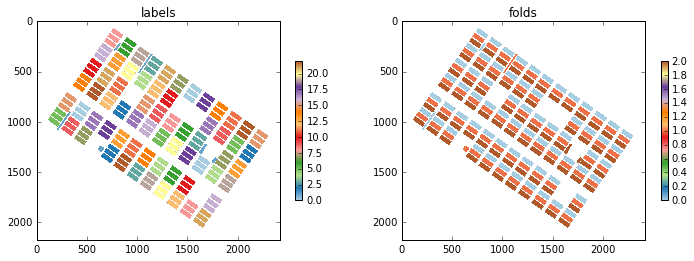

In [6]:
labels, id2label, folds, _ = classif2.load_labels(4)
id2label = np.array([unidecode.unidecode(l) for l in id2label])
nclasses = len(id2label)

print len(id2label), 'classes'

pl.figure(figsize=(12, 5))
pl.subplot(121)
pl.title('labels')
pl.imshow(labels, cmap=cm.Paired)
pl.colorbar(shrink=0.5)

pl.subplot(122)
pl.title('folds')
pl.imshow(folds, cmap=cm.Paired)
pl.colorbar(shrink=0.5)

In [7]:
for lab in id2label:
    print lab, "|",

Avoine | Bare soil | CC4CA | Chanvre | Chia | Feverole | Lentille | Lin | M blanche | Moha | Navette | Niger | Phacelie | Pois | R chinois | R fourrager | Sarepta | Sarrasin | Simplex | Sorgho | Tournesol | Trefle | Vesce |


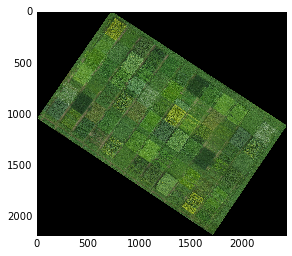

In [8]:
img_rgb = classif2.load_image('2013_10_08', 'rgb')
img_rgb = skimage.img_as_float(img_rgb).astype(np.float32)
pl.imshow(img_rgb)

# Extract windows Op

In [15]:
winsize = 50

img_t = theano.tensor.tensor3()
win_ij_t = theano.tensor.matrix(dtype='int32')

windows_2d = my_ops.extract_2d_windows(winsize)(img_t, win_ij_t)
extract_windows = theano.function(
    [img_t, win_ij_t],
    windows_2d,
)

In [16]:
print '--pre compilation'
theano.printing.debugprint(windows_2d)  
print
print '--post compilation'
theano.printing.debugprint(extract_windows)  

--pre compilation
Extract2DWindowsOp{hws1=25, hws2=25} [@A] ''   
 |<TensorType(float32, 3D)> [@B]
 |<TensorType(int32, matrix)> [@C]

--post compilation
HostFromGpu [@A] ''   6
 |Extract2DWindowsGpuOp{hws1=25, hws2=25} [@B] ''   5
   |GpuContiguous [@C] ''   3
   | |GpuFromHost [@D] ''   1
   |   |<TensorType(float32, 3D)> [@E]
   |GpuContiguous [@F] ''   4
     |GpuFromHost [@G] ''   2
       |Elemwise{Cast{float32}} [@H] ''   0
         |<TensorType(int32, matrix)> [@I]


In [17]:
extract_windows.maker.fgraph.toposort()

[Elemwise{Cast{float32}}(<TensorType(int32, matrix)>),
 GpuFromHost(<TensorType(float32, 3D)>),
 GpuFromHost(Elemwise{Cast{float32}}.0),
 GpuContiguous(GpuFromHost.0),
 GpuContiguous(GpuFromHost.0),
 Extract2DWindowsGpuOp{hws1=25, hws2=25}(GpuContiguous.0, GpuContiguous.0),
 HostFromGpu(Extract2DWindowsGpuOp{hws1=25, hws2=25}.0)]

In [18]:
win_ij = np.array([
    [500, 500],
    [1200, 800]
], dtype=np.int32)
out_win = extract_windows(img_rgb, win_ij)
out_win = np.array(out_win)

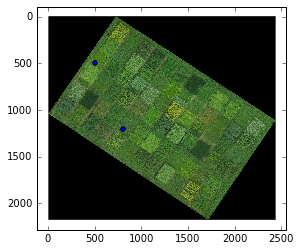

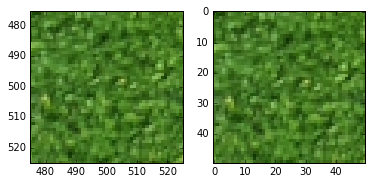

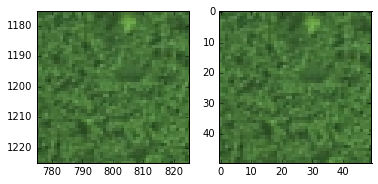

In [19]:
pl.imshow(img_rgb)
pl.scatter(win_ij[:,1], win_ij[:,0])

for c, (i, j) in enumerate(win_ij):
    pl.figure()
    pl.subplot(121)
    pl.imshow(img_rgb, interpolation='nearest')
    hws = winsize / 2
    pl.xlim((j - hws, j + hws))
    pl.ylim((i + hws, i - hws))
    pl.subplot(122)
    pl.imshow(out_win[c].transpose(1, 2, 0), interpolation='nearest')

# Extract hist1d Op

In [20]:
nbins = (20)
binranges = [(0, 1), (0, 1), (0, 1)]

windows = theano.tensor.tensor4()
extract_hist = theano.function(
    [windows],
    my_ops.extract_hist_1d(nbins, binranges)(windows),
)

In [21]:
theano.printing.debugprint(extract_hist)  

HostFromGpu [@A] ''   3
 |ExtractHist1DGpuOp{nbins=20, binranges=((0, 1), (0, 1), (0, 1))} [@B] ''   2
   |GpuContiguous [@C] ''   1
     |GpuFromHost [@D] ''   0
       |<TensorType(float32, 4D)> [@E]


In [22]:
out_hist = extract_hist(out_win)
out_hist = np.array(out_hist)
out_hist.shape

(2, 3, 20)

In [23]:
def plot_hist(ax, H):
    i = 0
    for chan, color in zip(range(3), ['r', 'g', 'b']):
        ax.bar(np.arange(20) + 0.5, H[chan],
               width=0.5, color=color, alpha=0.5)
        i += 20

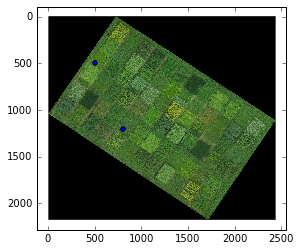

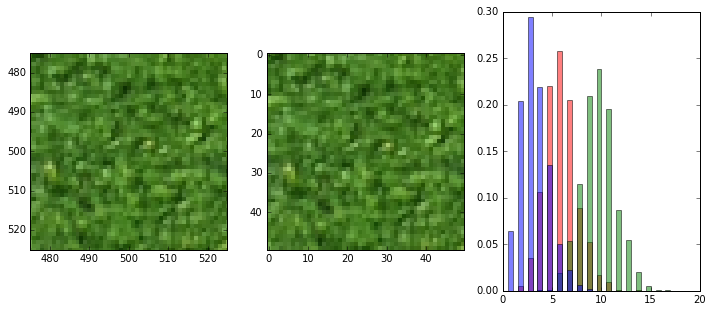

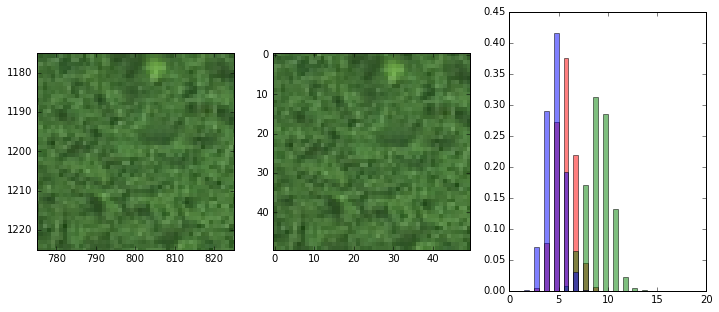

In [24]:
pl.imshow(img_rgb)
pl.scatter(win_ij[:,1], win_ij[:,0])

for pi, (i, j) in enumerate(win_ij):
    pl.figure(figsize=(12, 5))
    pl.subplot(131)
    pl.imshow(img_rgb, interpolation='nearest')
    hws = winsize / 2
    pl.xlim((j - hws, j + hws))
    pl.ylim((i + hws, i - hws))
    pl.subplot(132)
    pl.imshow(out_win[pi].transpose(1, 2, 0), interpolation='nearest')
    ax = pl.subplot(133)
    plot_hist(ax, out_hist[pi])